In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Utils & variables

In [2]:
raw  = pd.read_csv('data/covid_19_data.csv')
border_date = '2020-04-20'
days_from_today = 5

In [3]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

# Data clearing and visualization

In [4]:
#https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model/notebook#Dataset-and-tools

data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
        "Congo (Brazzaville)": "Congo",
        "The, Bahamas": "Bahamas",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped['Place'] = ncov_df_ungrouped['Country'] + ' '  + ncov_df_ungrouped['Province']
ncov_df_ungrouped = ncov_df_ungrouped.drop('Country', 1)
ncov_df_ungrouped = ncov_df_ungrouped.drop('Province', 1)
ncov_df_ungrouped.tail()

,Date,Confirmed,Infected,Deaths,Recovered,Place
18322,2020-04-24,473,466,7,0,US Wyoming
18323,2020-04-24,76,0,3,73,China Xinjiang
18324,2020-04-24,11,11,0,0,Canada Yukon
18325,2020-04-24,185,3,2,180,China Yunnan
18326,2020-04-24,1268,11,1,1256,China Zhejiang


In [5]:
training = ncov_df_ungrouped[(ncov_df_ungrouped['Date'] > '2013-01-01') & (ncov_df_ungrouped['Date'] < border_date)]
test = ncov_df_ungrouped[ncov_df_ungrouped['Date'] >= border_date]

In [6]:
places = ncov_df_ungrouped['Place'].unique()
places

array(['China Anhui', 'China Beijing', 'China Chongqing', 'China Fujian',
       'China Gansu', 'China Guangdong', 'China Guangxi', 'China Guizhou',
       'China Hainan', 'China Hebei', 'China Heilongjiang', 'China Henan',
       'Hong Kong Hong Kong', 'China Hubei', 'China Hunan',
       'China Inner Mongolia', 'China Jiangsu', 'China Jiangxi',
       'China Jilin', 'China Liaoning', 'Macau Macau', 'China Ningxia',
       'China Qinghai', 'China Shaanxi', 'China Shandong',
       'China Shanghai', 'China Shanxi', 'China Sichuan', 'Taiwan Taiwan',
       'China Tianjin', 'China Tibet', 'US Washington', 'China Xinjiang',
       'China Yunnan', 'China Zhejiang', 'Japan -', 'Thailand -',
       'South Korea -', 'Singapore -', 'Philippines -', 'Malaysia -',
       'Vietnam -', 'Australia -', 'Mexico -', 'Brazil -', 'Colombia -',
       'US Chicago', 'France -', 'US Illinois', 'Nepal -',
       'US California', 'US Arizona', 'Canada Ontario', 'Cambodia -',
       'Sri Lanka -', 'Ivory Coas

In [7]:
germany =  ncov_df_ungrouped[ncov_df_ungrouped['Place'] == 'Germany -']
germany_test =  test[test['Place'] == 'Germany -']
germany_training =  training[training['Place'] == 'Germany -']


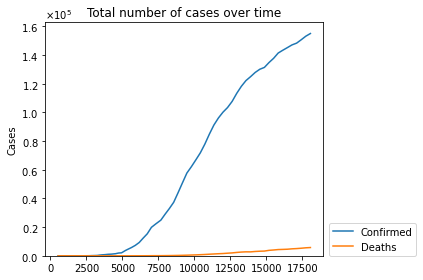

In [8]:
cols = ['Confirmed', 'Deaths']
line_plot(germany[cols], "Total number of cases over time")

# Simple linear model

In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, N, k, x0):
    return N / (1 + np.exp(-k * (x - x0)))

def exponenta(x, a , b, c, x0):
    return a * np.power(b, x-x0) + c

def poli(x, a , b, c, d):
    return a * np.power(x, 3) + b * np.power(x, 2) + c * np.power(x, 1) + d

def getError(x, y, func, params):
    N = len(x)
    return 1/N * (np.square(y - func(x, *params)).sum())

functions = [sigmoid, exponenta, poli]

def getDataSet(dataset, label):
    data = dataset[label]
    y = data.to_numpy()
    if y[len(y) -1 ] > 500:
        y0 = np.where(y > 100)[0][0]
        y = y[y0:]
    x = np.array(list(range(0,len(y))))
    return (x,y)

def fitFuntion(dataset, label, verbose = False): 
    x, y = getDataSet(dataset, label)
    bestFitFunc = {}
    minError = -1
    fitting = []
    for f in functions:
        try: 
            popt, pcov = curve_fit(f, x, y)
        except:
            continue
        err = getError(x, y, f, popt)
        ob = {'error': err, 'function': f, 'pcov': pcov, 'popt': popt}
        fitting.append(ob)
        if minError == -1 or err < minError:
            minError = err 
            bestFitFunc = ob
    if verbose:
        for res in fitting:
            print("function: " +  str(res['function'].__name__) + " err: " + str(res['error']) +  " params: ", str(res['popt']))
    return bestFitFunc
def plotResult(dataset, label, bestFitFunc):
    x, y = getDataSet(dataset, label)
    func = bestFitFunc['function']
    popt = bestFitFunc['popt']
    plt.axvline(x=len(x)-days_from_today, ymin=0, ymax=y[len(y)-1], color='r')
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, func(x, *popt), 'g--', label='estimation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

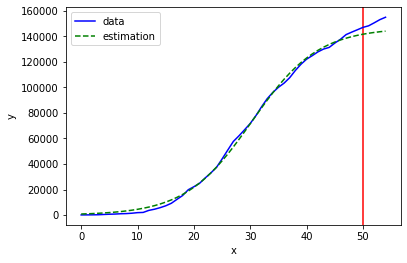

Used Method: sigmoid


In [10]:
fit = fitFuntion(germany_training, 'Confirmed')
plotResult(germany, 'Confirmed', fit)
print("Used Method: " + fit['function'].__name__)

/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


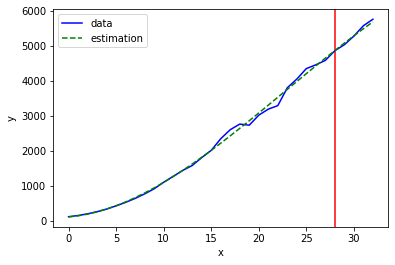

Used Method: poli


In [11]:
fit = fitFuntion(germany_training, 'Deaths')
plotResult(germany, 'Deaths', fit)
print("Used Method: " + fit['function'].__name__)

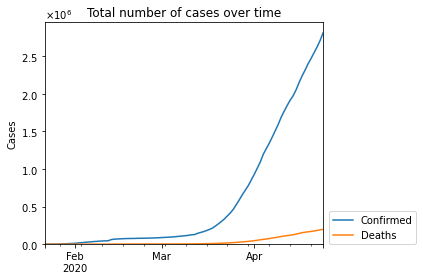

,Confirmed,Infected,Deaths,Recovered
Date,,,,
2020-01-22,555,510,17,28
2020-01-23,653,605,18,30
2020-01-24,941,879,26,36
2020-01-25,1438,1357,42,39
2020-01-26,2118,2010,56,52
...,...,...,...,...
2020-04-20,2472259,1656535,169986,645738
2020-04-21,2549123,1692721,176583,679819
2020-04-22,2623960,1731200,183066,709694


In [12]:
global_dt = ncov_df_ungrouped.drop('Place', 1).groupby(['Date']).sum()
global_training = global_dt[(global_dt.index > '2013-01-01') & (global_dt.index < border_date)]
line_plot(global_dt[cols], "Total number of cases over time")
global_dt

function: sigmoid err: 1168243624.433547 params:  [3.12504419e+06 1.12385625e-01 7.77153838e+01]
function: exponenta err: 7133345786.001274 params:  [ 1.38035624e+02  1.06179322e+00 -4.09964465e+04 -7.67429653e+01]
function: poli err: 2707559198.986719 params:  [ 1.06448327e+01 -8.02648753e+02  1.78541650e+04 -6.00355276e+04]


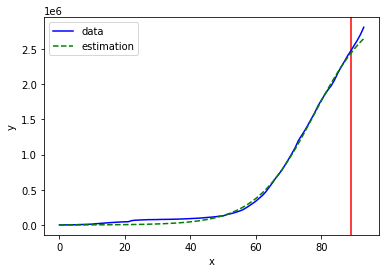

Used Method: sigmoid
Error : 1168243624.433547


In [13]:
fit = fitFuntion(global_training, 'Confirmed', verbose = True)
plotResult(global_dt, 'Confirmed', fit)
print("Used Method: " + fit['function'].__name__)
print("Error : " + str(fit['error']))

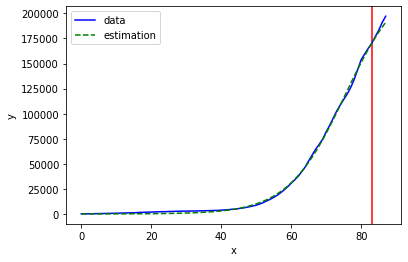

Used Method: sigmoid
Error : 1973162.9550586846


In [14]:
fit = fitFuntion(global_training, 'Deaths')
plotResult(global_dt, 'Deaths', fit)
print("Used Method: " + fit['function'].__name__)
print("Error : " + str(fit['error']))

# Enchancment for global model (measure model based on sum of predictions for each country)

In [15]:
def fillToN(y, N):
    w = np.zeros(N - len(y))
    return np.concatenate((w,y))    
    
def getErrorGlobal(y, agg):
    N = len(y)
    print(N)
    return 1/N * (np.square(y - agg).sum())
    
def predict_global(label):
    print("Nuber of separate places used in estimation: " + str(len(places)))
    funcMap = {'sigmoid': 0, 'poli': 0, 'exponenta': 0}
    N = 110
    x, y = getDataSet(global_dt, label)
    x = list(range(N))
    y = fillToN(y, N)
    agg = np.zeros(N)
    for place in places:
        dt = ncov_df_ungrouped[ncov_df_ungrouped['Place'] == place]
        dt_training =  training[training['Place'] ==  place]
        fit = fitFuntion(dt_training, label)
        a, b = getDataSet(dt, label)
        if 'function' in fit:
            func = fit['function']
            funcMap[func.__name__] += 1 
            popt = fit['popt']
            y_fited = fillToN(func(a, *popt), N)
            agg = agg + y_fited

    print("Square error: " + str(getErrorGlobal(y, agg)))
    print("function usage in fitting: ")
    print(funcMap)
    plt.axvline(x=len(x)-days_from_today, ymin=0, ymax=y[len(y)-1], color='r')
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, agg, 'g--', label='estimation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

Nuber of separate places used in estimation: 514


/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


110
Square error: 78655822.37444298
function usage in fitting: 
{'sigmoid': 51, 'poli': 331, 'exponenta': 60}


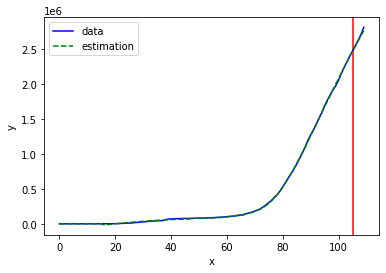

In [16]:
predict_global('Confirmed')

Nuber of separate places used in estimation: 514


/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


110
Square error: 1779285.7375481683
function usage in fitting: 
{'sigmoid': 146, 'poli': 146, 'exponenta': 159}


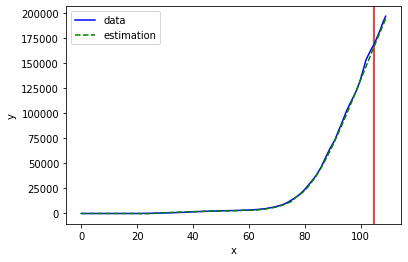

In [17]:
predict_global('Deaths')

# Simple XGBRegressor

In [73]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBRegressor

In [74]:
def prepareDataForXGBRegressor(data):
    year = []
    month = []
    day = []
    for el in data.Date:
        e = str(el).split(" ")[0].split("-")
        year.append(e[0])
        month.append(e[1])
        day.append(e[2])
    data['Month'] = month
    data['Day'] = day
    del data['Date']
    del data['Recovered']
    data['Confirmed'] = data['Confirmed'].apply(int)
    data['Infected'] = data['Infected'].apply(int)
    data['Deaths'] = data['Deaths'].apply(int)
    data['Month'] = data['Month'].apply(int)
    data['Day'] = data['Day'].apply(int)

In [75]:
lb = LabelEncoder()
scaler = MinMaxScaler()

In [76]:
XGBtraining = training.copy()
prepareDataForXGBRegressor(XGBtraining)
XGBtrainingLabeled = XGBtraining.copy()
XGBtraining['Place'] = lb.fit_transform(XGBtraining['Place'])

confirmed = XGBtraining.Confirmed
deaths = XGBtraining.Deaths
infected = XGBtraining.Infected

del XGBtraining['Confirmed']
del XGBtraining['Infected']
del XGBtraining['Deaths']

XGBtraining

,Place,Month,Day
0,74,1,22
1,75,1,22
2,76,1,22
3,77,1,22
4,78,1,22
...,...,...,...
16724,498,4,19
16725,102,4,19
16726,67,4,19
16727,103,4,19


In [77]:
XGBtestWithAnswers = test.copy()
prepareDataForXGBRegressor(XGBtestWithAnswers)
XGBtest = XGBtestWithAnswers.copy()
del XGBtest['Confirmed']
del XGBtest['Infected']
del XGBtest['Deaths']
XGBtest['Place'] = lb.transform(XGBtest['Place'])
XGBtest

,Place,Month,Day
16729,1,4,20
16730,2,4,20
16731,3,4,20
16732,4,4,20
16733,5,4,20
...,...,...,...
18322,498,4,24
18323,102,4,24
18324,67,4,24
18325,103,4,24


In [78]:
x_train = scaler.fit_transform(XGBtraining.values)
x_test = scaler.transform(XGBtest.values)

In [79]:
# minErr = 1000000000
# minD = 0
# minE = 0
# estimators = list(range(100,2000, 100))
# depth = list(range(4,6,1))
# for d in depth:
#     for e in estimators: 
#         rf = XGBRegressor(n_estimators = e , random_state = 0 , max_depth = d)
#         rf.fit(x_train,confirmed)
#         cases_pred = rf.predict(x_test)
#         t = XGBtestWithAnswers.copy()
#         t["predicted_confirmed"] = cases_pred
#         germany = t[t['Place'] == 'Germany -']
#         N = len(germany.predicted_confirmed)
#         err = 1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()
#         print(d, e, err)
#         if(err< minErr):
#             print("NEW MIN !!!!!" + str(err))
#             minErr = err
#             minD = d
#             minE = e

In [80]:
rf1 = XGBRegressor(n_estimators = 1800 , random_state = 0 , max_depth = 4)
rf1.fit(x_train,confirmed)

rf = XGBRegressor(n_estimators = 200000)
rf.fit(x_train,confirmed)


rfd = XGBRegressor(n_estimators = 1800 , random_state = 0 , max_depth = 4)
rfd.fit(x_train,deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1800, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [81]:
cases_pred1 = rf1.predict(x_test)
cases_pred = rf.predict(x_test)
deths_pred = rfd.predict(x_test)

cases_pred_train1 = rf1.predict(x_train)
cases_pred_train = rf.predict(x_train)
deths_pred_train = rfd.predict(x_train)
cases_pred

array([ 927.9331  ,  575.9799  , 2576.4434  , ...,    3.521155,
        -85.050186,  885.3424  ], dtype=float32)

In [82]:
XGBtestWithAnswers["predicted_confirmed"] = cases_pred
XGBtestWithAnswers["predicted_confirmed1"] = cases_pred1
XGBtestWithAnswers["predicted_deaths"] = deths_pred
XGBtestWithAnswers

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
16729,1026,855,36,Afghanistan -,4,20,927.933105,882.649841,28.137831
16730,584,231,26,Albania -,4,20,575.979919,726.959900,31.367586
16731,2718,1235,384,Algeria -,4,20,2576.443359,2429.119385,360.177399
16732,717,432,37,Andorra -,4,20,715.620361,867.869202,39.002972
16733,24,16,2,Angola -,4,20,21.994886,168.818420,7.138822
...,...,...,...,...,...,...,...,...,...
18322,473,466,7,US Wyoming,4,24,382.699341,890.417297,11.443136
18323,76,0,3,China Xinjiang,4,24,-180.110153,30.577114,-0.169880
18324,11,11,0,Canada Yukon,4,24,3.521155,191.231125,17.806404
18325,185,3,2,China Yunnan,4,24,-85.050186,160.084244,2.600094


In [83]:
XGBtrainingLabeled["predicted_confirmed"] = cases_pred_train
XGBtrainingLabeled["predicted_confirmed1"] = cases_pred_train1
XGBtrainingLabeled["predicted_deaths"] = deths_pred_train
XGBtrainingLabeled

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
0,1,1,0,China Anhui,1,22,0.991609,47.616783,1.580058
1,14,14,0,China Beijing,1,22,14.012419,-40.150955,1.390967
2,6,6,0,China Chongqing,1,22,5.995695,87.248802,2.024722
3,1,1,0,China Fujian,1,22,0.992737,-8.101639,0.362955
4,0,0,0,China Gansu,1,22,0.014883,-45.289734,0.266226
...,...,...,...,...,...,...,...,...,...
16724,313,311,2,US Wyoming,4,19,313.028198,769.080811,18.579535
16725,76,0,3,China Xinjiang,4,19,76.036522,75.544449,5.325396
16726,9,9,0,Canada Yukon,4,19,8.983722,182.635025,10.558747
16727,184,4,2,China Yunnan,4,19,183.934708,205.051666,7.096083


# Germany

In [84]:
germany =  XGBtrainingLabeled[XGBtrainingLabeled['Place'] == 'Germany -']
N = len(germany.predicted_confirmed)
germany

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
530,8,8,0,Germany -,2,1,8.001757,-135.643600,44.028427
595,10,10,0,Germany -,2,2,10.004848,148.364685,4.514588
662,12,12,0,Germany -,2,3,11.991415,23.535242,7.138055
730,12,12,0,Germany -,2,4,11.992772,-116.081131,52.177158
800,12,12,0,Germany -,2,5,12.038644,114.760834,-30.830944
...,...,...,...,...,...,...,...,...,...
15190,134753,58349,3804,Germany -,4,15,134752.828125,135941.890625,3754.821045
15510,137698,56646,4052,Germany -,4,16,137698.015625,137827.218750,3917.670166
15830,141397,53931,4352,Germany -,4,17,141397.156250,140395.562500,4246.233887
16150,143342,53483,4459,Germany -,4,18,143341.859375,141100.453125,4323.441406


In [85]:
1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()

0.014199713816047227

In [86]:
1/N * (np.square(germany.predicted_confirmed1 - germany.Confirmed)).sum()

3449933.553320088

In [87]:
1/N * (np.square(germany.predicted_deaths - germany.Deaths)).sum()

3408.1069465002915

In [88]:
germany = XGBtestWithAnswers[XGBtestWithAnswers['Place'] == 'Germany -']
N = len(germany.predicted_confirmed)
germany

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
16790,147065,50703,4862,Germany -,4,20,146754.890625,145320.078125,4610.037598
17110,148291,48058,5033,Germany -,4,21,143048.968750,146171.156250,4615.177734
17430,150648,45969,5279,Germany -,4,22,145158.421875,146527.703125,4612.774902
17749,153129,44254,5575,Germany -,4,23,145040.187500,152272.859375,4633.860840
18069,154999,39439,5760,Germany -,4,24,146058.875000,151534.187500,4644.781250


In [89]:
1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()

40613050.023339845

In [90]:
1/N * (np.square(germany.predicted_confirmed1 - germany.Confirmed)).sum()

7450647.728466798

In [91]:
1/N * (np.square(germany.predicted_deaths - germany.Deaths)).sum()

562274.4315450191

# Global

In [92]:
XGBtestWithAnswers['Date'] =  XGBtestWithAnswers.Month * 30 +  XGBtestWithAnswers.Day
del XGBtestWithAnswers["Month"]
del XGBtestWithAnswers["Day"]
global_dt = XGBtestWithAnswers.drop('Place', 1).groupby(['Date']).sum()
N = len(XGBtestWithAnswers.predicted_confirmed)
global_dt

,Confirmed,Infected,Deaths,predicted_confirmed,predicted_confirmed1,predicted_deaths
Date,,,,,,
140,2472259,1656535,169986,2397178.75,2410931.75,165174.218750
141,2549123,1692721,176583,2394155.50,2422852.25,164980.312500
142,2623960,1731200,183066,2406143.50,2433146.25,164409.031250
143,2708885,1779541,190858,2401289.00,2446680.00,166375.359375
144,2811193,1820433,197159,2397425.75,2453961.00,166465.531250


In [93]:
1/N * (np.square(global_dt.predicted_confirmed - global_dt.Confirmed)).sum()

214589883.64025345

In [94]:
1/N * (np.square(global_dt.predicted_confirmed1 - global_dt.Confirmed)).sum()

157998363.53954163

In [95]:
1/N *(np.square(global_dt.predicted_deaths - global_dt.Deaths)).sum()

1281193.2383223476